In [1]:
###=== MODEL PREPARATION ===###


import os, random
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# random seed
os.environ["PYTHONHASHSEED"] = "0"
np.random.seed(42); random.seed(42)


df = pd.read_csv("processed_valorant_dataset.csv")

# all features, check 00_data_inspect for logic and code
FEATURES = [
    'map_pool_advantage',
    'r2_advantage',
    'winrate_advantage',
    'recent_form',
    'consistency_advantage',
    'rolling_round_diff'
]


# customizable date
def prepare(df, *, start_date="2023-01-01"):
    """Fresh, deterministic prep + 80/20 time split. Never mutates caller data."""
    d = df.copy()

    
    d['date'] = pd.to_datetime(d['date'], errors='coerce')
    d = d.sort_values('date').reset_index(drop=True)


    if start_date is not None:
        d = d[d['date'] >= pd.Timestamp(start_date)].copy()

   

    # 75/25 split by date
    split_date = d['date'].quantile(0.75)
    train = d[d['date'] <  split_date].copy()
    test  = d[d['date'] >= split_date].copy()

    Xtr = train[FEATURES].copy()
    Xte = test[FEATURES].copy()
    ytr = (train['result'] == 'W').astype(int)
    yte = (test['result']  == 'W').astype(int)

    return dict(df=d, train=train, test=test, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, split_date=split_date)


In [2]:
###=== MODEL RESULTS ===###


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

P = prepare(df)
X_train, X_test = P["Xtr"], P["Xte"]
y_train_numeric, y_test_numeric = P["ytr"], P["yte"]

model = LogisticRegression(solver="lbfgs", max_iter=2000, C=10, random_state=42)
model.fit(X_train, y_train_numeric)

train_pred = model.predict(X_train)
test_pred  = model.predict(X_test)

train_accuracy = accuracy_score(y_train_numeric, train_pred)
test_accuracy  = accuracy_score(y_test_numeric,  test_pred)

print("MODEL RESULTS:")
print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy:  {test_accuracy:.3f}")


MODEL RESULTS:
Train Accuracy: 0.584
Test Accuracy:  0.650


In [3]:
#=== IDEAL FEATURE COMBINATION ===#
from itertools import combinations

results = []
for r in range(1, len(FEATURES) + 1):
    for combo in combinations(FEATURES, r):
        combo = list(combo)
        model = LogisticRegression(solver="lbfgs", max_iter=2000, C=10, random_state=42)
        model.fit(X_train[combo], y_train_numeric)
        test_acc = accuracy_score(y_test_numeric, model.predict(X_test[combo]))
        results.append((combo, test_acc))

# top 5 best combinations
results.sort(key=lambda x: x[1], reverse=True)
print("Top 5 feature combinations:")
for combo, acc in results[:5]:
    print(f"{acc:.3f}: {combo}")

Top 5 feature combinations:
0.650: ['map_pool_advantage', 'r2_advantage', 'winrate_advantage', 'recent_form', 'consistency_advantage', 'rolling_round_diff']
0.642: ['map_pool_advantage', 'r2_advantage', 'winrate_advantage', 'recent_form', 'consistency_advantage']
0.640: ['map_pool_advantage', 'r2_advantage', 'winrate_advantage', 'consistency_advantage']
0.637: ['map_pool_advantage', 'r2_advantage', 'consistency_advantage']
0.635: ['map_pool_advantage', 'winrate_advantage', 'consistency_advantage', 'rolling_round_diff']


In [4]:
# === ABLATION ANALYSIS === #

from collections import OrderedDict
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# helpers
def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    margin = z * np.sqrt((p*(1-p) + (z**2)/(4*n)) / n) / denom
    return (center - margin, center + margin)

def try_mcnemar_p(y_true, pred_full, pred_alt):
    """
    Returns (p_value, b, c) where:
      b = full wrong & alt correct
      c = full correct & alt wrong
    Tries exact McNemar from statsmodels; falls back to binomial (scipy) or None.
    """
    y_true = np.asarray(y_true)
    pred_full = np.asarray(pred_full)
    pred_alt = np.asarray(pred_alt)

    b = np.sum((pred_full != y_true) & (pred_alt == y_true))
    c = np.sum((pred_full == y_true) & (pred_alt != y_true))

    # If no b and c pairs, p = 1 (default)
    if (b + c) == 0:
        return 1.0, int(b), int(c)

    # Try statsmodels exact McNemar
    try:
        from statsmodels.stats.contingency_tables import mcnemar
        res = mcnemar([[0, b], [c, 0]], exact=True)
        return float(res.pvalue), int(b), int(c)
    except Exception:
        pass

    # Try scipy binomial test on the smaller of (b,c), two-sided
    try:
        from scipy.stats import binomtest
        p = float(binomtest(k=min(b, c), n=b+c, p=0.5, alternative="two-sided").pvalue)
        return p, int(b), int(c)
    except Exception:
        # Fallback: no p-value available
        return np.nan, int(b), int(c)


full_features = FEATURES[:]  # ['map_pool_advantage', 'r2_advantage', 'h2h_advantage', 'winrate_advantage', 'recent_form', 'consistency_advantage']
n_test = len(y_test_numeric)

# using acc_full and pred_full from model results
acc_full = test_accuracy
pred_full = test_pred  # 0/1 predictions from the full model
k_full = int(round(acc_full * n_test))
ci_full = wilson_ci(k_full, n_test)

rows = []
rows.append(OrderedDict({
    "Removed": "None (full)",
    "Test Acc": round(acc_full, 3),
    "95% CI": f"[{ci_full[0]:.3f}, {ci_full[1]:.3f}]",
    "Δ vs Full (pp)": 0.0,
    "McNemar p": "",
    "b,c": ""
}))

#leave-one-out ablation
for rem in full_features:
    keep = [f for f in full_features if f != rem]

    # Fit ablated model with identical hyperparams and split
    ab_model = LogisticRegression(solver="lbfgs", max_iter=2000, C=10, random_state=42)
    ab_model.fit(X_train[keep], y_train_numeric)

    # Evaluate on test
    ab_pred = ab_model.predict(X_test[keep])
    acc_ab = accuracy_score(y_test_numeric, ab_pred)
    k_ab = int(round(acc_ab * n_test))
    ci_ab = wilson_ci(k_ab, n_test)

    # Paired comparison to full via McNemar (or fallback)
    pval, b, c = try_mcnemar_p(y_test_numeric, pred_full, ab_pred)

    rows.append(OrderedDict({
        "Removed": rem,
        "Test Acc": round(acc_ab, 3),
        "95% CI": f"[{ci_ab[0]:.3f}, {ci_ab[1]:.3f}]",
        "Δ vs Full (pp)": round((acc_ab - acc_full) * 100, 2),
        "McNemar p": (f"{pval:.4f}" if isinstance(pval, float) else ""),
        "b,c": f"{b},{c}"
    }))

# ablation table creation
ab_df = pd.DataFrame(rows)
if len(ab_df) > 1:
    head = ab_df.iloc[[0]]
    tail = ab_df.iloc[1:].sort_values(by="Δ vs Full (pp)", ascending=True)
    ab_df = pd.concat([head, tail], ignore_index=True)

print("\n=== LEAVE-ONE-OUT ABLATION (Test Set) ===")
print(ab_df.to_string(index=False))



=== LEAVE-ONE-OUT ABLATION (Test Set) ===
              Removed  Test Acc         95% CI  Δ vs Full (pp) McNemar p   b,c
          None (full)     0.650 [0.601, 0.695]            0.00                
   map_pool_advantage     0.584 [0.535, 0.631]           -6.60    0.0034 24,50
         r2_advantage     0.622 [0.573, 0.668]           -2.79    0.0708 10,21
          recent_form     0.629 [0.581, 0.676]           -2.03    0.1849 10,18
consistency_advantage     0.632 [0.583, 0.678]           -1.78    0.2810 12,19
    winrate_advantage     0.635 [0.586, 0.681]           -1.52    0.4966 24,30
   rolling_round_diff     0.642 [0.594, 0.688]           -0.76    0.6900 11,14


In [5]:
###=== MODEL VALIDATION ===###
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def comprehensive_validation(P, X_train, X_test, y_train, y_test, test_accuracy, train_accuracy):
    print("=== COMPREHENSIVE MODEL VALIDATION ===\n")

    features = X_train.columns

    # simply how much each feature independently contributes to prediction
    print("1. INDIVIDUAL FEATURE PREDICTIVE POWER:")
    for feature in features:
        m = LogisticRegression(solver="lbfgs", max_iter=2000, C=10.0, random_state=42)
        m.fit(X_train[[feature]], y_train)
        tr = m.score(X_train[[feature]], y_train)
        te = m.score(X_test[[feature]], y_test)
        print(f"{feature}:\n  Solo Train: {tr:.3f}, Solo Test: {te:.3f}, Gap: {te-tr:+.3f}")
        if te - tr > 0.05: print("   SUSPICIOUS: Test much higher than train")
        if te > 0.65:      print("   SUSPICIOUS: Single feature too powerful")

    # Time-based cross validation over the whole (train+test) chronologically
    print("\n2. TIME-BASED CROSS VALIDATION:")
    full = pd.concat([
        P["train"][["date"]].assign(y=y_train.values).join(X_train),
        P["test"][["date"]].assign(y=y_test.values).join(X_test)
    ]).sort_values("date").reset_index(drop=True)

    X_all = full[features].to_numpy()
    y_all = full["y"].to_numpy()

    tscv = TimeSeriesSplit(n_splits=4)
    cv_scores = []
    for i, (tr_idx, va_idx) in enumerate(tscv.split(X_all), 1):
        m = LogisticRegression(solver="lbfgs", max_iter=2000, C=10.0, random_state=42)
        m.fit(X_all[tr_idx], y_all[tr_idx])
        tr = m.score(X_all[tr_idx], y_all[tr_idx])
        va = m.score(X_all[va_idx], y_all[va_idx])
        cv_scores.append(va)
        print(f"  Fold {i}: Train {tr:.3f} ({len(tr_idx)} matches), Val {va:.3f} ({len(va_idx)} matches), Gap {va-tr:+.3f}")
    print(f"  CV Mean: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

    # majority baseline comparision
    print("\n3. MAJORITY BASELINE COMPARISON:")
    majority = max(y_test.mean(), 1 - y_test.mean())
    print(f"Majority baseline (test): {majority:.3f}")
    print(f"Model improvement over baseline: {test_accuracy - majority:.3f}")

    # Feature importances (coef magnitude)
    print("\n4. FEATURE IMPORTANCE ANALYSIS:")
    main_model = LogisticRegression(solver="lbfgs", max_iter=2000, C=10, random_state=42)
    main_model.fit(X_train, y_train)
    for name, imp in zip(features, np.abs(main_model.coef_[0])):
        print(f"  {name}: {imp:.4f}")

    # Bootstrap stability
    print("\n5. MODEL STABILITY TEST (Bootstrap):")
    rng = np.random.RandomState(42)
    boot = []
    for _ in range(1000):
        idx = rng.choice(len(X_train), size=len(X_train), replace=True)
        m = LogisticRegression(solver="lbfgs", max_iter=2000, C=10, random_state=42)
        m.fit(X_train.iloc[idx], y_train.iloc[idx])
        boot.append(m.score(X_test, y_test))
    print(f"  Bootstrap test scores: {np.mean(boot):.3f} ± {np.std(boot):.3f}")
    print(f"  Your model vs bootstrap mean: {test_accuracy - np.mean(boot):+.3f}")

    # IGNORE - H2H validation (to check % of matches with h2h data)
    if 'h2h_advantage' in features:
        print("\n6. H2H VALIDATION:")
        early = P["df"][P["df"]['date'] < '2024-01-01']
        late  = P["df"][P["df"]['date'] >= '2024-01-01']
        if len(early) and len(late):
            print(f"  Early period H2H mean:  {early['h2h_advantage'].mean():.3f}")
            print(f"  Recent period H2H mean: {late['h2h_advantage'].mean():.3f}")
            print(f"  Early default H2H: {(early['h2h_advantage']==0.5).mean():.1%}")
            print(f"  Recent default H2H:{(late['h2h_advantage']==0.5).mean():.1%}")

    # 7) Sanity checks
    print("\n7. FINAL SANITY CHECKS:")
    print(f"  Features have reasonable ranges? {all(np.abs(X_train.mean()) < 10)}")
    print(f"  No single feature dominates? {np.max(np.abs(main_model.coef_)) < 5}")
    print(f"  Model not overfitting badly? {abs(test_accuracy - train_accuracy) < 0.1}")
    print(f"  Performance above baseline? {test_accuracy > majority}")
    print("\n=== VALIDATION COMPLETE ===")
    return cv_scores

_ = comprehensive_validation(P, X_train, X_test, y_train_numeric, y_test_numeric, test_accuracy, train_accuracy)


=== COMPREHENSIVE MODEL VALIDATION ===

1. INDIVIDUAL FEATURE PREDICTIVE POWER:
map_pool_advantage:
  Solo Train: 0.576, Solo Test: 0.538, Gap: -0.038
r2_advantage:
  Solo Train: 0.539, Solo Test: 0.553, Gap: +0.014
winrate_advantage:
  Solo Train: 0.562, Solo Test: 0.584, Gap: +0.022
recent_form:
  Solo Train: 0.539, Solo Test: 0.556, Gap: +0.017
consistency_advantage:
  Solo Train: 0.517, Solo Test: 0.505, Gap: -0.012
rolling_round_diff:
  Solo Train: 0.556, Solo Test: 0.538, Gap: -0.017

2. TIME-BASED CROSS VALIDATION:
  Fold 1: Train 0.603 (310 matches), Val 0.586 (309 matches), Gap -0.017
  Fold 2: Train 0.585 (619 matches), Val 0.570 (309 matches), Gap -0.015
  Fold 3: Train 0.587 (928 matches), Val 0.583 (309 matches), Gap -0.005
  Fold 4: Train 0.583 (1237 matches), Val 0.654 (309 matches), Gap +0.071
  CV Mean: 0.598 ± 0.033

3. MAJORITY BASELINE COMPARISON:
Majority baseline (test): 0.513
Model improvement over baseline: 0.137

4. FEATURE IMPORTANCE ANALYSIS:
  map_pool_advan

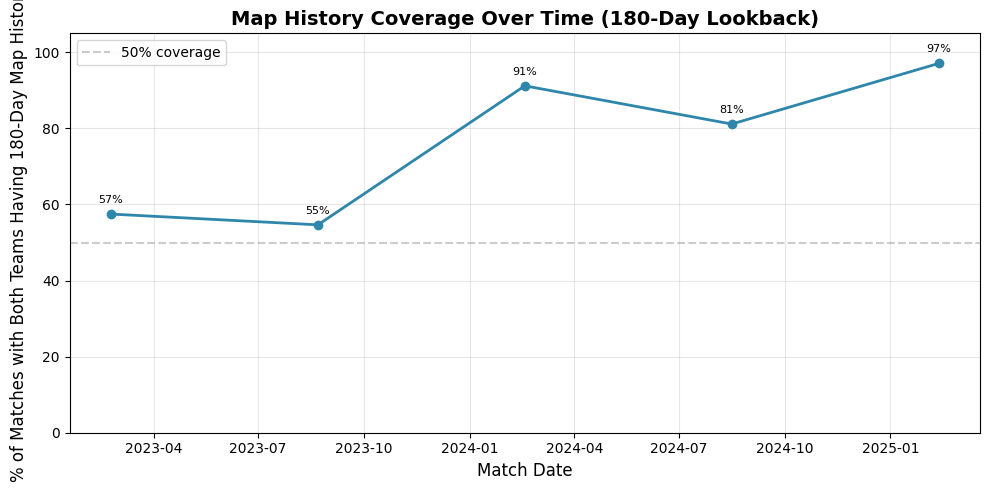

        date  matches  pct_with_history
0 2023-02-23      167         57.485030
1 2023-08-22       86         54.651163
2 2024-02-18      466         91.201717
3 2024-08-16      313         81.150160
4 2025-02-12      514         97.081712


In [6]:
###=== HISTORICAL MAP DATA COVERAGE ANALYSIS ===###

import matplotlib.pyplot as plt

base = prepare(df)["df"].copy()
base['date'] = pd.to_datetime(base['date'], errors='coerce')
base = base.sort_values('date').reset_index(drop=True)

def has_recent_history(row, team_col):
    cutoff = row['date'] - pd.Timedelta(days=180)
    past = base[(base[team_col] == row[team_col]) & (base['date'] < row['date']) & (base['date'] >= cutoff)]
    return len(past) > 0

base['my_recent'] = base.apply(lambda r: has_recent_history(r, 'team_name'), axis=1)
base['opp_recent'] = base.apply(lambda r: has_recent_history(r, 'opponent'), axis=1)
base['both_recent'] = base['my_recent'] & base['opp_recent']

coverage = (base
    .groupby(pd.Grouper(key='date', freq='180D'))
    .agg(matches=('both_recent','size'),
         pct_with_history=('both_recent', lambda x: 100 * x.mean()))
    .reset_index()
)
coverage = coverage[coverage['matches'] > 5]

coverage = coverage[coverage['matches'] > 5]

# plot
plt.figure(figsize=(10,5))
plt.plot(coverage['date'], coverage['pct_with_history'], marker='o', linewidth=2, color='#2E86AB')
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.4, label='50% coverage')
plt.ylim(0, 105)
plt.title('Map History Coverage Over Time (180-Day Lookback)', fontsize=14, fontweight='bold')
plt.xlabel('Match Date', fontsize=12)
plt.ylabel('% of Matches with Both Teams Having 180-Day Map History', fontsize=12)
for i, row in coverage.iterrows():
    plt.annotate(f"{row['pct_with_history']:.0f}%", (row['date'], row['pct_with_history']),
                 textcoords="offset points", xytext=(0,8), ha='center', fontsize=8)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print table for reference
print(coverage)


Analyzing 1546 matches from 2023-02-23 to 2025-07-13
time_chunk
Chunk 1    515
Chunk 2    515
Chunk 3    516
Name: count, dtype: int64

=== Chunk 1 Analysis ===
Total matches: 515
Baseline: 51.7%
Model accuracy: 54.3%
Improvement: +2.6 pp
Train size: 386, Test size: 129

=== Chunk 2 Analysis ===
Total matches: 515
Baseline: 55.0%
Model accuracy: 60.5%
Improvement: +5.5 pp
Train size: 386, Test size: 129

=== Chunk 3 Analysis ===
Total matches: 516
Baseline: 51.7%
Model accuracy: 62.0%
Improvement: +10.3 pp
Train size: 387, Test size: 129

=== Summary ===
Chunk 1: Model 54.3% vs Baseline 51.7% (n=515)
Chunk 2: Model 60.5% vs Baseline 55.0% (n=515)
Chunk 3: Model 62.0% vs Baseline 51.7% (n=516)


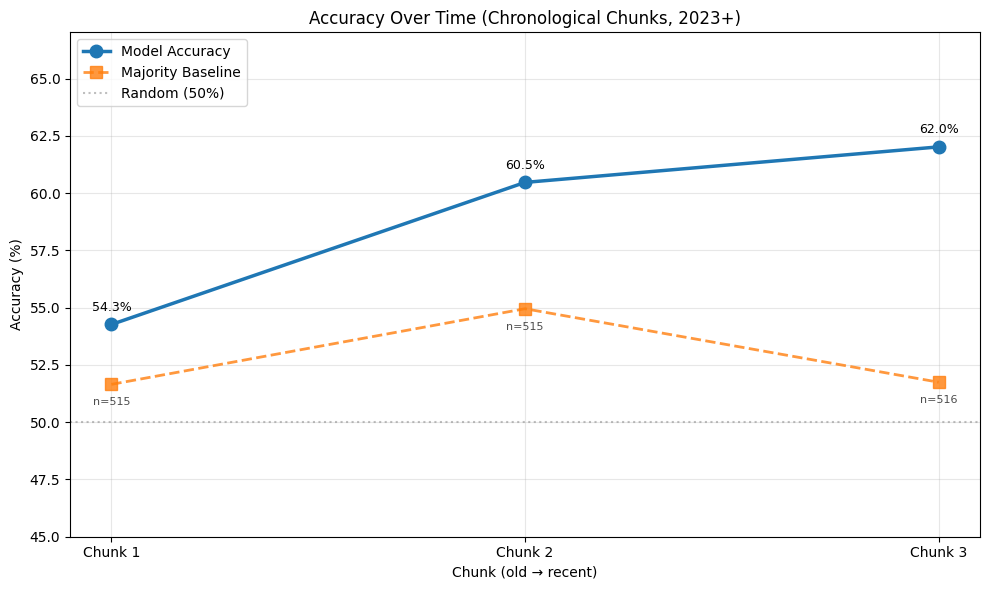

In [7]:
### TEMPORAL CHUNK BASED ANALYSIS ###


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# fresh, sorted frame from prepare()
chron = prepare(df, start_date="2023-01-01")["df"].copy()
chron = chron.sort_values("date").reset_index(drop=True)

# add numeric target
chron["target_numeric"] = (chron["result"] == "W").astype(int)

# split into 3 equal-sized chronological chunks by index
n = len(chron)
if n < 3:
    raise ValueError("Not enough rows to form 3 chunks.")
edges = np.linspace(0, n, 4, dtype=int)  # 0, ~n/3, ~2n/3, n
labels = ["Chunk 1", "Chunk 2", "Chunk 3"]
chron["time_chunk"] = pd.cut(
    np.arange(n), bins=edges, labels=labels, include_lowest=True, right=False
)

print(f"Analyzing {n} matches from {chron['date'].min().date()} to {chron['date'].max().date()}")
print(chron["time_chunk"].value_counts().sort_index())

# evaluate per chunk
baselines, model_accuracies, sample_sizes = {}, {}, {}
for chunk in labels:
    part = chron[chron["time_chunk"] == chunk].copy()
    m = len(part)
    if m < 50:
        print(f"\nSkipping {chunk}: only {m} matches (need ≥ 50)")
        continue

    print(f"\n=== {chunk} Analysis ===")
    print(f"Total matches: {m}")

    # majority-class baseline for this chunk
    win_rate = (part["result"] == "W").mean()
    baseline = max(win_rate, 1 - win_rate) * 100
    baselines[chunk] = baseline
    sample_sizes[chunk] = m


    X = part[FEATURES].copy()
    y = part["target_numeric"].astype(int)

    # stratify only if both classes available
    strat = y if y.nunique() == 2 else None
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=strat
    )

    chunk_model = LogisticRegression(solver="lbfgs", max_iter=2000, C=10, random_state=42)
    chunk_model.fit(Xtr, ytr)
    acc = accuracy_score(yte, chunk_model.predict(Xte)) * 100
    model_accuracies[chunk] = acc

    print(f"Baseline: {baseline:.1f}%")
    print(f"Model accuracy: {acc:.1f}%")
    print(f"Improvement: +{(acc - baseline):.1f} pp")
    print(f"Train size: {len(Xtr)}, Test size: {len(Xte)}")

# summary + plot
if model_accuracies:
    print("\n=== Summary ===")
    for chunk in labels:
        if chunk in model_accuracies:
            print(f"{chunk}: Model {model_accuracies[chunk]:.1f}% vs Baseline {baselines[chunk]:.1f}% (n={sample_sizes[chunk]})")

    xs = [c for c in labels if c in model_accuracies]
    model_vals = [model_accuracies[c] for c in xs]
    base_vals  = [baselines[c] for c in xs]
    ns         = [sample_sizes[c] for c in xs]

    plt.figure(figsize=(10,6))
    plt.plot(xs, model_vals, 'o-', linewidth=2.5, markersize=9, label='Model Accuracy')
    plt.plot(xs, base_vals,  's--', linewidth=2.0, markersize=8, label='Majority Baseline', alpha=0.8)
    plt.axhline(50, color='gray', linestyle=':', alpha=0.5, label='Random (50%)')

    for i,(x,val) in enumerate(zip(xs, model_vals)):
        plt.annotate(f'{val:.1f}%', (i, val), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    for i,(x,nc) in enumerate(zip(xs, ns)):
        plt.annotate(f'n={nc}', (i, base_vals[i]), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, alpha=0.7)

    plt.title('Accuracy Over Time (Chronological Chunks, 2023+)')
    plt.xlabel('Chunk (old → recent)')
    plt.ylabel('Accuracy (%)')
    plt.ylim(45, max(model_vals + base_vals) + 5)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No chunks had sufficient data to evaluate.")


Acc: 0.650 | Brier: 0.2354 | LogLoss: 0.6633 | ECE: 0.0832
Pred range: 0.224–0.738 | Bin counts: [50, 49, 49, 49, 49, 49, 49, 50]

=== CONFIDENCE INTERVALS ===
Test Accuracy: 0.650 (95% CI: [0.602, 0.693])

Calibration Metrics:
  Brier Score: 0.2354 (lower is better)
  Log Loss: 0.6633
  ECE: 0.0832 (under 0.1 is good)
  Prediction range: [0.224, 0.738]

Prediction Confidence:
  Confident predictions (>60% or <40%): 74 (18.8%)
  Uncertain predictions (40-60%): 320 (81.2%)

Sample Predictions (first 5 matches):
  Match 1: Predicted Win (73.8% conf) | Actual: Win
  Match 2: Predicted Win (50.8% conf) | Actual: Win
  Match 3: Predicted Win (52.6% conf) | Actual: Loss
  Match 4: Predicted Loss (51.9% conf) | Actual: Loss
  Match 5: Predicted Loss (53.8% conf) | Actual: Loss

Statistical Significance:
  Model correct: 256/394 predictions
  P-value vs random guessing: 0.000000
  Significantly better than random? Yes


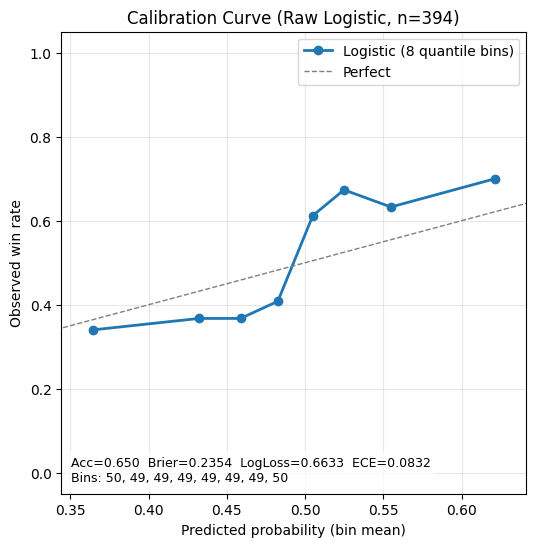

In [8]:
###===CALIBRATION CURVE & BRIER TEST===###



import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, brier_score_loss, log_loss

# making bins
def _bin_stats(y_true, y_prob, n_bins=8, strategy="quantile"):
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    if strategy == "quantile":
        edges = np.quantile(y_prob, np.linspace(0, 1, n_bins + 1))
        edges = np.unique(edges); n_bins = max(1, len(edges) - 1)
    elif strategy == "uniform":
        edges = np.linspace(0, 1, n_bins + 1)
    else:
        raise ValueError("strategy must be 'quantile' or 'uniform'")
    bin_id = np.digitize(y_prob, edges[1:-1], right=False)
    counts = np.array([(bin_id == i).sum() for i in range(n_bins)])
    x = np.array([y_prob[bin_id == i].mean() if counts[i] > 0 else np.nan for i in range(n_bins)])
    y = np.array([y_true[bin_id == i].mean() if counts[i] > 0 else np.nan for i in range(n_bins)])
    keep = ~np.isnan(x)
    return x[keep], y[keep], counts[keep], edges

#calibration stats
def calibration_summary(y_true, y_prob, n_bins=8, strategy="quantile"):
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    acc   = accuracy_score(y_true, (y_prob >= 0.5))
    brier = brier_score_loss(y_true, y_prob)
    ll    = log_loss(y_true, y_prob, labels=[0,1])
    x, y, counts, edges = _bin_stats(y_true, y_prob, n_bins, strategy)
    weights = counts / counts.sum()
    ece = np.sum(weights * np.abs(y - x))
    return {"accuracy": acc, "brier": brier, "logloss": ll, "ece": ece,
            "bin_x": x, "bin_y": y, "bin_counts": counts, "edges": edges,
            "n_bins": len(counts), "strategy": strategy}


# plot
def plot_calibration(y_true, y_prob, n_bins=8, strategy="quantile",
                     title="Calibration Curve (Raw Logistic)", zoom=True,
                     show_hist=False, ax=None):
    M = calibration_summary(y_true, y_prob, n_bins, strategy)
    x, y, counts = M["bin_x"], M["bin_y"], M["bin_counts"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    idx = np.argsort(x)
    ax.plot(x[idx], y[idx], 'o-', linewidth=2, label=f'Logistic ({M["n_bins"]} {strategy} bins)')
    ax.plot([0,1],[0,1],'--', linewidth=1, color='gray', label='Perfect')
    if show_hist:
        ax2 = ax.twinx(); ax2.hist(y_prob, bins=20, alpha=0.15); ax2.set_ylabel("Count")
    if zoom:
        ax.set_xlim(x.min()-0.02, x.max()+0.02)
    ax.set_title(title); ax.set_xlabel("Predicted probability (bin mean)"); ax.set_ylabel("Observed win rate")
    ax.grid(True, alpha=0.3); ax.legend(loc='best')
    txt = (f"Acc={M['accuracy']:.3f}  Brier={M['brier']:.4f}  "
           f"LogLoss={M['logloss']:.4f}  ECE={M['ece']:.4f}\n"
           f"Bins: {', '.join(map(str, counts.tolist()))}")
    ax.text(0.02, 0.02, txt, transform=ax.transAxes, fontsize=9,
            va="bottom", ha="left", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    return M, ax




p_raw = model.predict_proba(X_test)[:, 1]

M, ax = plot_calibration(
    y_test_numeric, p_raw,
    n_bins=8, strategy="quantile",
    title=f"Calibration Curve (Raw Logistic, n={len(y_test_numeric)})",
    zoom=True, show_hist=False
)

# nice summary printout
print(
    f"Acc: {M['accuracy']:.3f} | Brier: {M['brier']:.4f} | "
    f"LogLoss: {M['logloss']:.4f} | ECE: {M['ece']:.4f}"
)
print(
    f"Pred range: {p_raw.min():.3f}–{p_raw.max():.3f} | "
    f"Bin counts: {M['bin_counts'].tolist()}"
)






###=== ADDITIONAL CONFIDENCE ANALYSIS ===###

# Bootstrap Confidence Interval for Accuracy
def bootstrap_confidence_interval(y_true, y_pred, n_bootstraps=1000, confidence=0.95):
    accuracies = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstraps):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_pred_boot = y_pred[indices]
        acc = accuracy_score(y_true_boot, y_pred_boot)
        accuracies.append(acc)
    
    alpha = 1 - confidence
    lower = np.percentile(accuracies, alpha/2 * 100)
    upper = np.percentile(accuracies, (1 - alpha/2) * 100)
    
    return np.mean(accuracies), lower, upper

# Get predictions
test_pred = model.predict(X_test)

# Calculate confidence interval
mean_acc, lower_ci, upper_ci = bootstrap_confidence_interval(
    y_test_numeric, test_pred, n_bootstraps=1000
)

print("\n=== CONFIDENCE INTERVALS ===")
print(f"Test Accuracy: {M['accuracy']:.3f} (95% CI: [{lower_ci:.3f}, {upper_ci:.3f}])")

print(f"\nCalibration Metrics:")
print(f"  Brier Score: {M['brier']:.4f} (lower is better)")
print(f"  Log Loss: {M['logloss']:.4f}")
print(f"  ECE: {M['ece']:.4f} (under 0.1 is good)")
print(f"  Prediction range: [{p_raw.min():.3f}, {p_raw.max():.3f}]")

# Prediction Confidence Analysis
confident_predictions = np.sum((p_raw > 0.6) | (p_raw < 0.4))
uncertain_predictions = np.sum((p_raw >= 0.4) & (p_raw <= 0.6))

print(f"\nPrediction Confidence:")
print(f"  Confident predictions (>60% or <40%): {confident_predictions} ({confident_predictions/len(p_raw)*100:.1f}%)")
print(f"  Uncertain predictions (40-60%): {uncertain_predictions} ({uncertain_predictions/len(p_raw)*100:.1f}%)")

# Sample Predictions
print(f"\nSample Predictions (first 5 matches):")
for i in range(min(5, len(y_test_numeric))):
    actual = "Win" if y_test_numeric.iloc[i] == 1 else "Loss"
    predicted = "Win" if test_pred[i] == 1 else "Loss"
    confidence = p_raw[i] if test_pred[i] == 1 else (1 - p_raw[i])
    print(f"  Match {i+1}: Predicted {predicted} ({confidence:.1%} conf) | Actual: {actual}")

# Statistical Significance Test
from scipy.stats import binomtest
n_correct = np.sum(test_pred == y_test_numeric)
n_total = len(y_test_numeric)
result = binomtest(n_correct, n_total, 0.5, alternative='greater')
p_value = result.pvalue

print(f"\nStatistical Significance:")
print(f"  Model correct: {n_correct}/{n_total} predictions")
print(f"  P-value vs random guessing: {p_value:.6f}")
print(f"  Significantly better than random? {'Yes' if p_value < 0.05 else 'No'}")

plt.show()  # showing plot

In [9]:
### === COMING SOON === ###






# ###=== RANDOM FOREST IMPLEMENTATION ===###
# from sklearn.ensemble import RandomForestClassifier

# P_rf = prepare(df)  # or start_date="2023-01-01"
# X_train, X_test = P_rf["Xtr"], P_rf["Xte"]
# y_train_numeric, y_test_numeric = P_rf["ytr"], P_rf["yte"]

# print("="*50, "\nDEFAULT RANDOM FOREST")
# rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, max_features="sqrt")
# rf.fit(X_train, y_train_numeric)
# print(f"Train: {rf.score(X_train, y_train_numeric):.3f}")
# print(f"Test:  {rf.score(X_test,  y_test_numeric):.3f}")

# print("\n"+"="*50, "\nCONSERVATIVE RANDOM FOREST")
# rf_conservative = RandomForestClassifier(
#     n_estimators=200, max_depth=2, min_samples_split=50, min_samples_leaf=20,
#     max_features="sqrt", random_state=42, n_jobs=-1
# )
# rf_conservative.fit(X_train, y_train_numeric)
# print(f"Train: {rf_conservative.score(X_train, y_train_numeric):.3f}")
# print(f"Test:  {rf_conservative.score(X_test,  y_test_numeric):.3f}")

# best_rf = rf_conservative if rf_conservative.score(X_test, y_test_numeric) > rf.score(X_test, y_test_numeric) else rf
# print("\nFEATURE IMPORTANCES (", "conservative" if best_rf is rf_conservative else "default", ")")
# for name, imp in zip(FEATURES, best_rf.feature_importances_):
#     print(f"{name}: {imp:.3f}")

In [10]:
# # === COMPREHENSIVE VALIDATION FOR RANDOM FOREST (conservative) ===
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np
# import pandas as pd

# def comprehensive_validation_rf(P, X_train, X_test, y_train, y_test,
#                                 model=None, model_name="Conservative RF",
#                                 train_acc=None, test_acc=None):
#     """
#     Mirrors your logistic comprehensive_validation, but for Random Forest.
#     Uses the same conservative RF hyperparams throughout for consistency.
#     """
#     CONS_KW = dict(
#         n_estimators=200, max_depth=3, min_samples_split=50, min_samples_leaf=20,
#         max_features="sqrt", random_state=42, n_jobs=-1
#     )

#     features = list(X_train.columns)

#     # If a model isn't provided, train one with conservative settings
#     if model is None:
#         model = RandomForestClassifier(**CONS_KW).fit(X_train, y_train)

#     if train_acc is None: train_acc = model.score(X_train, y_train)
#     if test_acc  is None: test_acc  = model.score(X_test,  y_test)

#     print("=== COMPREHENSIVE MODEL VALIDATION (Random Forest) ===\n")
#     print(f"Model: {model_name}")
#     print(f"Train Accuracy: {train_acc:.3f}")
#     print(f"Test  Accuracy: {test_acc:.3f}\n")

#     # 1) Individual feature predictive power (RF on single feature)
#     print("1. INDIVIDUAL FEATURE PREDICTIVE POWER:")
#     for f in features:
#         m = RandomForestClassifier(**CONS_KW)
#         m.fit(X_train[[f]], y_train)
#         tr = m.score(X_train[[f]], y_train)
#         te = m.score(X_test[[f]],  y_test)
#         print(f"{f}:\n  Solo Train: {tr:.3f}, Solo Test: {te:.3f}, Gap: {te-tr:+.3f}")
#         if te - tr > 0.05: print("   SUSPICIOUS: Test much higher than train")
#         if te > 0.65:      print("   SUSPICIOUS: Single feature too powerful")

#     # 2) Time-based cross validation over (train+test) chronologically
#     print("\n2. TIME-BASED CROSS VALIDATION:")
#     # Expect P to have 'train' and 'test' with a 'date' column, like your logistic version
#     full = pd.concat([
#         P["train"][["date"]].assign(y=y_train.values).join(X_train),
#         P["test"][["date"]].assign(y=y_test.values).join(X_test)
#     ]).sort_values("date").reset_index(drop=True)

#     X_all = full[features].to_numpy()
#     y_all = full["y"].to_numpy()

#     tscv = TimeSeriesSplit(n_splits=4)
#     cv_scores = []
#     for i, (tr_idx, va_idx) in enumerate(tscv.split(X_all), 1):
#         m = RandomForestClassifier(**CONS_KW)
#         m.fit(X_all[tr_idx], y_all[tr_idx])
#         tr = m.score(X_all[tr_idx], y_all[tr_idx])
#         va = m.score(X_all[va_idx], y_all[va_idx])
#         cv_scores.append(va)
#         print(f"  Fold {i}: Train {tr:.3f} ({len(tr_idx)} matches), Val {va:.3f} ({len(va_idx)} matches), Gap {va-tr:+.3f}")
#     print(f"  CV Mean: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

#     # 3) Random baseline (majority class)
#     print("\n3. RANDOM BASELINE COMPARISON:")
#     majority = max(y_test.mean(), 1 - y_test.mean())
#     print(f"Majority baseline (test): {majority:.3f}")
#     print(f"Model improvement over baseline: {test_acc - majority:.3f}")

#     # 4) Feature importances (Gini)
#     print("\n4. FEATURE IMPORTANCE ANALYSIS:")
#     if hasattr(model, "feature_importances_"):
#         for name, imp in zip(features, model.feature_importances_):
#             print(f"  {name}: {imp:.4f}")
#     else:
#         print("  (Model has no feature_importances_)")

#     # 5) Bootstrap stability (deterministic)
#     print("\n5. MODEL STABILITY TEST (Bootstrap):")
#     rng = np.random.RandomState(42)
#     boot = []
#     n = len(X_train)
#     for _ in range(200):
#         idx = rng.choice(n, size=n, replace=True)
#         m = RandomForestClassifier(**CONS_KW)
#         m.fit(X_train.iloc[idx], y_train.iloc[idx])
#         boot.append(m.score(X_test, y_test))
#     print(f"  Bootstrap test scores: {np.mean(boot):.3f} ± {np.std(boot):.3f}")
#     print(f"  Your model vs bootstrap mean: {test_acc - np.mean(boot):+.3f}")

#     # 6) H2H validation (if available in P['df'])
#     if isinstance(P, dict) and ('df' in P) and ('h2h_advantage' in P['df'].columns):
#         print("\n6. H2H VALIDATION:")
#         early = P["df"][P["df"]['date'] < '2024-01-01']
#         late  = P["df"][P["df"]['date'] >= '2024-01-01']
#         if len(early) and len(late):
#             print(f"  Early period H2H mean:  {early['h2h_advantage'].mean():.3f}")
#             print(f"  Recent period H2H mean: {late['h2h_advantage'].mean():.3f}")
#             print(f"  Early default H2H: {(early['h2h_advantage']==0.5).mean():.1%}")
#             print(f"  Recent default H2H:{(late['h2h_advantage']==0.5).mean():.1%}")
#     else:
#         print("\n6. H2H VALIDATION:")
#         print("  (Skipped — 'df' or 'h2h_advantage' not available in P)")

#     # 7) Sanity checks
#     print("\n7. FINAL SANITY CHECKS:")
#     # Rough feature range check (same spirit as your logistic)
#     try:
#         mean_ok = bool((np.abs(X_train.mean()) < 10).all())
#     except Exception:
#         mean_ok = True
#     # "No single feature dominates?" -> use importance threshold for RF
#     dom_ok = True
#     try:
#         dom_ok = float(np.max(model.feature_importances_)) < 0.5
#     except Exception:
#         pass
#     print(f"  Features have reasonable ranges? {mean_ok}")
#     print(f"  No single feature dominates? {dom_ok}")
#     print(f"  Model not overfitting badly? {abs(test_acc - train_acc) < 0.10}")
#     print(f"  Performance above baseline? {test_acc > majority}")
#     print("\n=== VALIDATION COMPLETE ===")
#     return cv_scores

# # Run it for your conservative RF
# _ = comprehensive_validation_rf(P_rf, X_train, X_test, y_train_numeric, y_test_numeric,
#                                 model=rf_conservative, model_name="Conservative RF",
#                                 train_acc=rf_conservative.score(X_train, y_train_numeric),
#                                 test_acc=rf_conservative.score(X_test,  y_test_numeric))
